In [106]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve
)
from IPython.display import display
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier

# Thư viện xử lý mất cân bằng
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["figure.dpi"] = 120
np.random.seed(42)


# num_cols = ["age","trestbps","chol","thalach","oldpeak","ca"]
# cat_cols = ["sex","cp","fbs","restecg","exang","slope","thal"]


In [107]:
cols = ["age","sex","cp","trestbps","chol","fbs","restecg","thalach",
        "exang","oldpeak","slope","ca","thal","target"]

df = pd.read_csv("data/heart+disease/processed.cleveland.data", header=None, names=cols)
df = df.replace("?", np.nan)
for c in df.columns:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df["target"] = (df["target"] > 0).astype(int)
df.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


ca          4
thal        2
cp          0
trestbps    0
age         0
sex         0
fbs         0
chol        0
restecg     0
thalach     0
oldpeak     0
exang       0
slope       0
target      0
dtype: int64


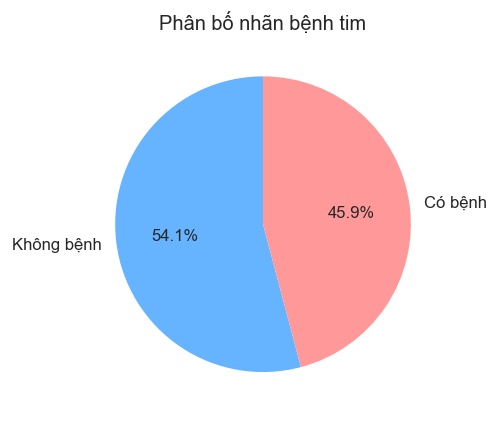

In [108]:
# Kiểm tra dữ liệu thiếu
missing = df.isna().sum().sort_values(ascending=False)
print(missing)

# Vẽ biểu đồ pie class balance
fig, ax = plt.subplots(figsize=(4,4))
df["target"].replace({0:"Không bệnh", 1:"Có bệnh"}).value_counts().plot(
    kind="pie", autopct="%.1f%%", startangle=90, colors=["#66b3ff", "#ff9999"], ax=ax
)
ax.set_ylabel("")
plt.title("Phân bố nhãn bệnh tim")
plt.show(); plt.close()


Tổng quan dữ liệu:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,299.000000,301.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.672241,4.734219,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,0.937438,1.939706,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,3.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,3.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,1.000000,7.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,7.000000,1.000000


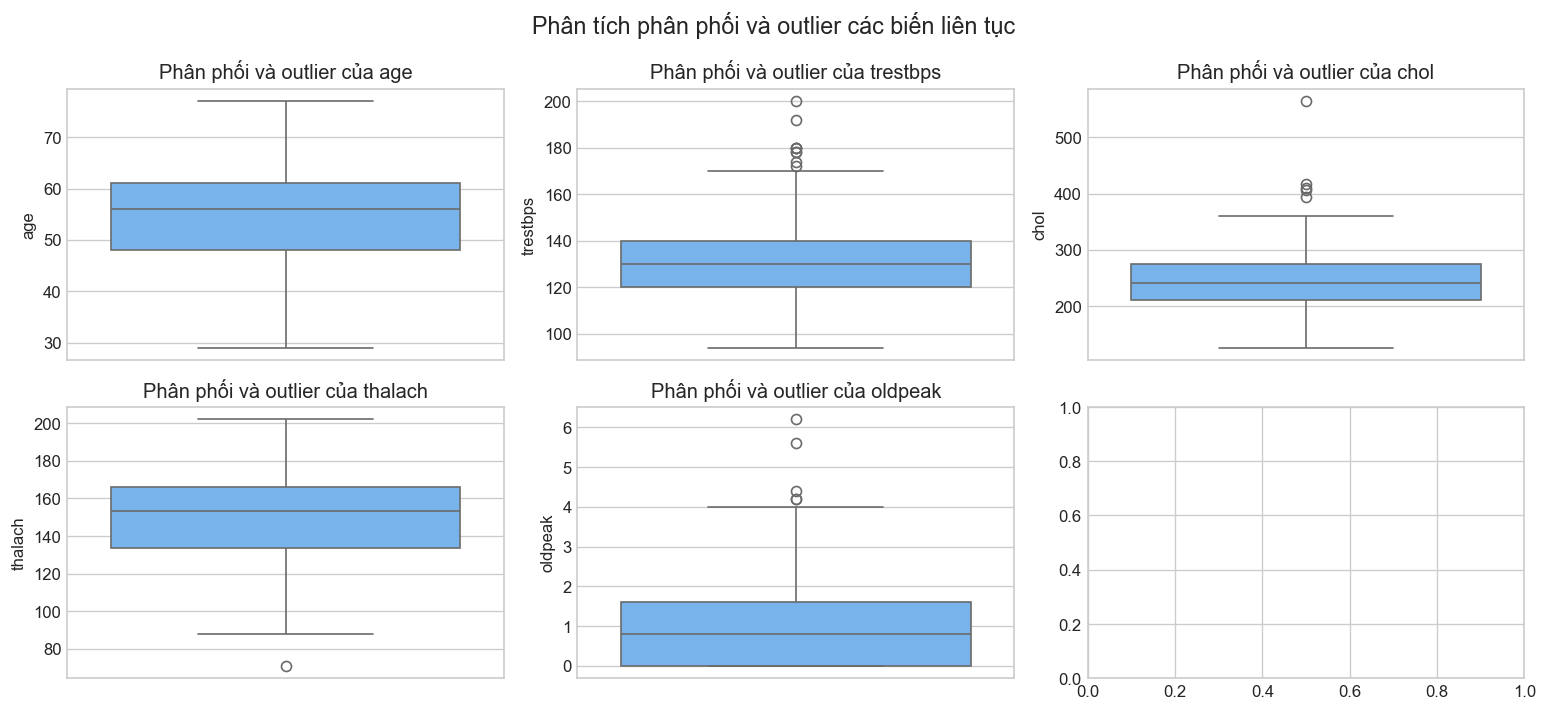

In [109]:
print("Tổng quan dữ liệu:")
display(df.describe())

# Kiểm tra outlier bằng boxplot
num_cols_plot = ["age","trestbps","chol","thalach","oldpeak"]
fig, axes = plt.subplots(2, 3, figsize=(13,6))
axes = axes.ravel()
for i, col in enumerate(num_cols_plot):
    sns.boxplot(y=df[col], ax=axes[i], color="#66b3ff")
    axes[i].set_title(f"Phân phối và outlier của {col}")
plt.suptitle("Phân tích phân phối và outlier các biến liên tục", fontsize=14)
plt.tight_layout(); plt.show(); plt.close()



## Phân tích tương quan và tuyến tính
thalach (nhịp tim tối đa) tương quan âm mạnh với target: người có tim khỏe có nhịp tim cao hơn.

oldpeak, trestbps, chol tương quan dương → tăng khi có bệnh.

Không có biến nào hoàn toàn tuyến tính → nên chọn mô hình phi tuyến (RF, SVM) thay vì chỉ Logistic Regression.


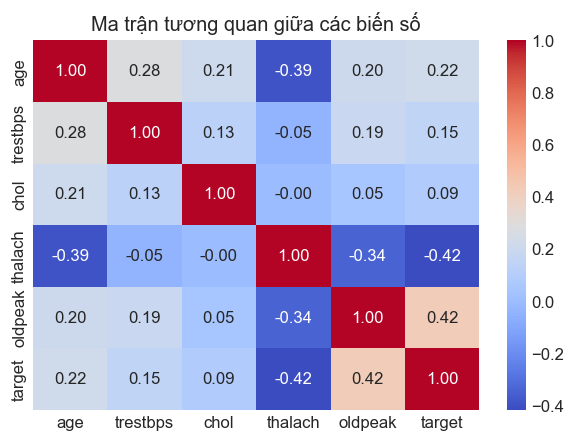

In [110]:
numeric_cols = ["age","trestbps","chol","thalach","oldpeak"]
corr = df[numeric_cols + ["target"]].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Ma trận tương quan giữa các biến số")
plt.show(); plt.close()


In [111]:
X = df.drop(columns=["target"])
y = df["target"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

num_cols = ["age","trestbps","chol","thalach","oldpeak","ca"]
cat_cols = ["sex","cp","fbs","restecg","exang","slope","thal"]

# Tiền xử lý có imputation
numeric_tf = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_tf = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore"))])
preprocess_impute = ColumnTransformer([("num", numeric_tf, num_cols), ("cat", categorical_tf, cat_cols)])


In [112]:
models = {
    "Logistic Regression": Pipeline([
        ("pre", preprocess_impute),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", random_state=42))
    ]),
    "Decision Tree": Pipeline([
        ("pre", preprocess_impute),
        ("clf", DecisionTreeClassifier(max_depth=4, random_state=42))
    ]),
    "Random Forest": Pipeline([
        ("pre", preprocess_impute),
        ("clf", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"))
    ]),
    "Ada Boost": Pipeline([
        ("pre", preprocess_impute),
        ("clf", AdaBoostClassifier(n_estimators=300, random_state=42))
    ]),
    "Gradient Boosting": Pipeline([
        ("pre", preprocess_impute),
        ("clf", GradientBoostingClassifier(random_state=42))
    ]),
    "SVM (RBF)": Pipeline([
        ("pre", preprocess_impute),
        ("clf", SVC(kernel="rbf", probability=True, random_state=42))
    ]),
}


Logistic Regression: AUC trung bình = 0.915 ± 0.022
Decision Tree: AUC trung bình = 0.802 ± 0.056
Random Forest: AUC trung bình = 0.912 ± 0.022
Ada Boost: AUC trung bình = 0.894 ± 0.021
Gradient Boosting: AUC trung bình = 0.883 ± 0.020
SVM (RBF): AUC trung bình = 0.902 ± 0.035


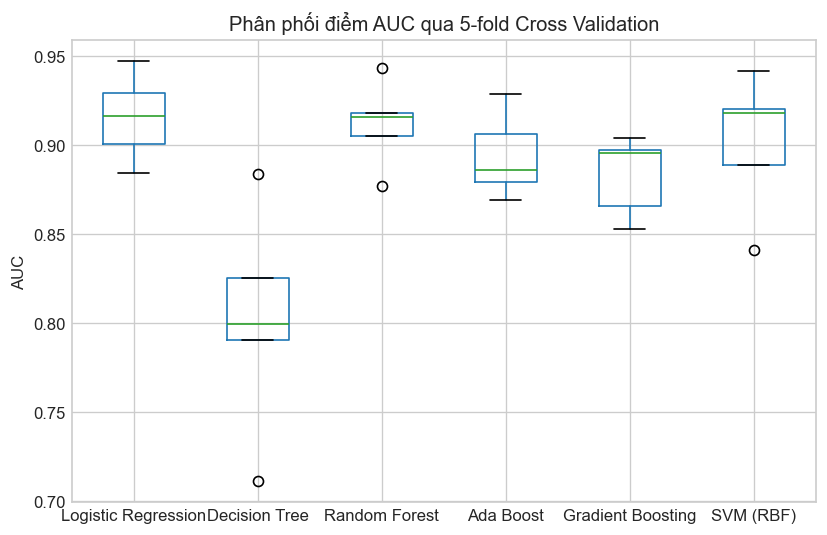

In [113]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, pipe in models.items():
    auc_scores = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
    cv_results[name] = auc_scores
    print(f"{name}: AUC trung bình = {auc_scores.mean():.3f} ± {auc_scores.std():.3f}")

# Biểu đồ so sánh
cv_df = pd.DataFrame({name: scores for name, scores in cv_results.items()})
cv_df.boxplot(figsize=(8,5))
plt.title("Phân phối điểm AUC qua 5-fold Cross Validation")
plt.ylabel("AUC")
plt.show(); plt.close()

In [114]:
def evaluate_models(models, X_tr, y_tr, X_te, y_te, title, use_fixed_threshold=False):
    # Vẽ ROC chung cho tất cả mô hình
    plt.figure(figsize=(6,4))
    metrics = []

    for name, model in models.items():
        model.fit(X_tr, y_tr)
        y_score = model.predict_proba(X_te)[:, 1]

        # ROC & AUC
        fpr, tpr, _ = roc_curve(y_te, y_score)
        auc = roc_auc_score(y_te, y_score)
        plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

        # Chọn ngưỡng
        if use_fixed_threshold:
            th_opt = 0.5
        else:
            prec, rec, thr = precision_recall_curve(y_te, y_score)
            f1s = 2 * prec * rec / (prec + rec + 1e-12)
            best_idx = int(np.argmax(f1s))
            # 'thr' dài hơn kém 1 phần tử so với 'f1s'
            th_opt = 0.5 if best_idx >= len(thr) else max(thr[best_idx], 0.5)

        # Dự đoán theo ngưỡng
        y_pred = (y_score >= th_opt).astype(int)

        # Confusion Matrix (mỗi mô hình một figure riêng)
        cm = confusion_matrix(y_te, y_pred)
        ConfusionMatrixDisplay(cm).plot(colorbar=False, cmap="Blues")
        plt.title(f"{name} – Confusion Matrix (thr={th_opt:.2f})")
        plt.tight_layout(); plt.show(); plt.close()

        # Lưu chỉ số
        metrics.append({
            "Model": name,
            "AUC": auc,
            "Accuracy": accuracy_score(y_te, y_pred),
            "Precision": precision_score(y_te, y_pred),
            "Recall": recall_score(y_te, y_pred),
            "F1": f1_score(y_te, y_pred)
        })

    # Hoàn thiện ROC chung
    plt.plot([0,1], [0,1], '--', alpha=0.6)
    plt.legend(); plt.title(title)
    plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity")
    plt.tight_layout(); plt.show(); plt.close()

    return pd.DataFrame(metrics).sort_values(["AUC","F1"], ascending=[False, False])


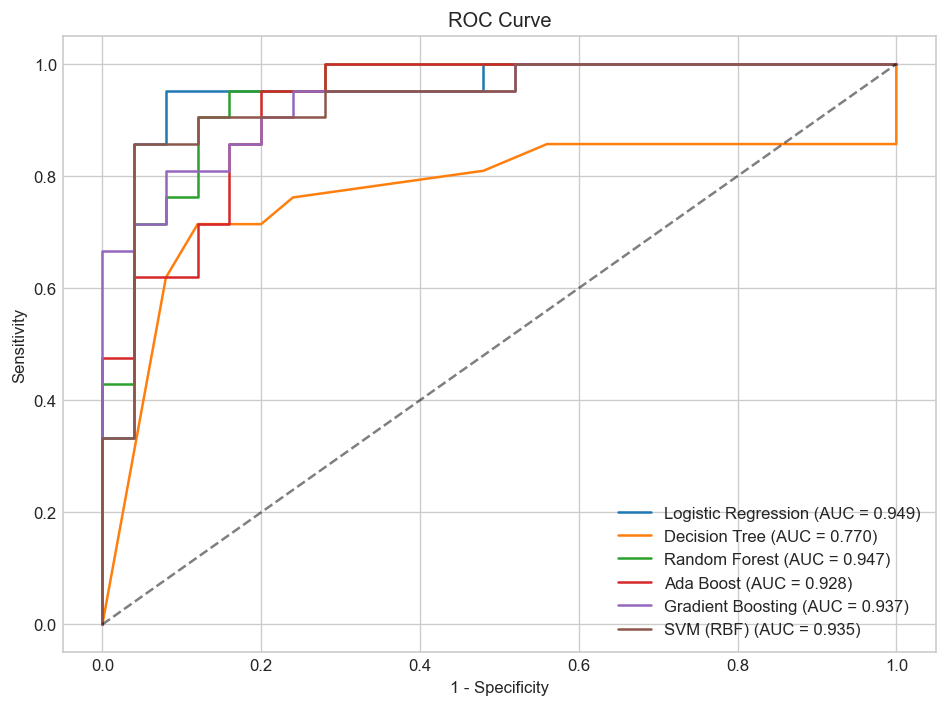

,Model,AUC
0,Logistic Regression,0.948571
2,Random Forest,0.946667
4,Gradient Boosting,0.937143
5,SVM (RBF),0.935238
3,Ada Boost,0.927619
1,Decision Tree,0.770476


In [115]:


# Vẽ ROC giống hình mẫu (mọi mô hình chung một hình)
plt.figure(figsize=(8,6))
auc_table = []
for name, pipe in models.items():
    pipe.fit(X_train, y_train)
    y_score = pipe.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    auc_table.append((name, auc))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0,1], [0,1], "--", color="black", alpha=0.5)
plt.title("ROC Curve")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show(); plt.close()

pd.DataFrame(auc_table, columns=["Model","AUC"]).sort_values("AUC", ascending=False)


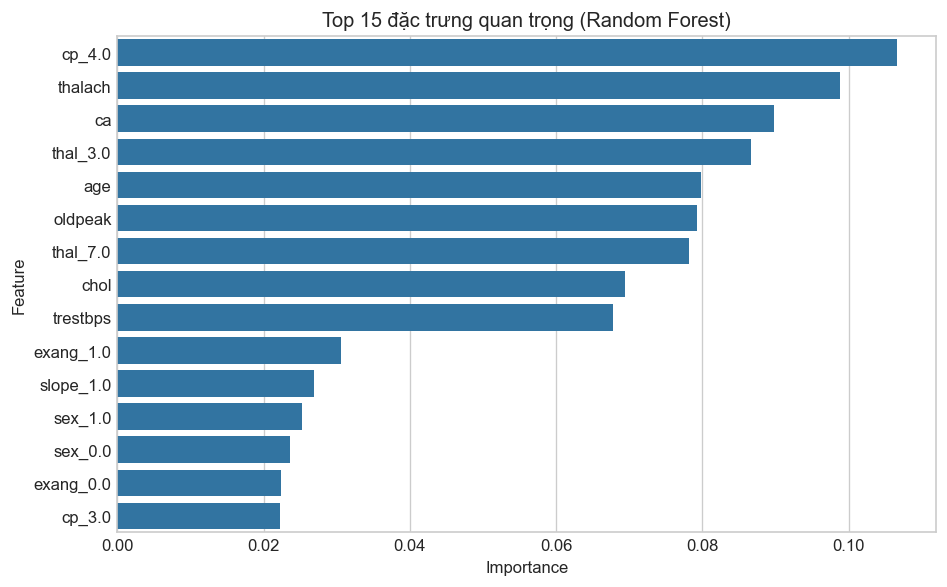

In [116]:
# Fit lại RF để lấy importance (dùng đúng pipeline đã train)
rf_pipe = models["Random Forest"]
rf_pipe.fit(X_train, y_train)

# Lấy tên cột sau OneHot
ohe = rf_pipe.named_steps["pre"].transformers_[1][1].named_steps["onehot"]
cat_feature_names = ohe.get_feature_names_out(cat_cols)
all_features = np.concatenate([num_cols, cat_feature_names])

importances = rf_pipe.named_steps["clf"].feature_importances_
feat_imp = pd.DataFrame({"Feature": all_features, "Importance": importances}) \
            .sort_values("Importance", ascending=False).head(15)

plt.figure(figsize=(8,5))
sns.barplot(data=feat_imp, x="Importance", y="Feature")
plt.title("Top 15 đặc trưng quan trọng (Random Forest)")
plt.tight_layout(); plt.show(); plt.close()


BẢNG SO SÁNH HIỆU NĂNG MÔ HÌNH


,Model,AUC,Accuracy,Precision,Recall,F1
0,Logistic Regression,0.948571,0.913043,0.869565,0.952381,0.909091
2,Random Forest,0.946667,0.869565,0.826087,0.904762,0.863636
4,Gradient Boosting,0.937143,0.826087,0.782609,0.857143,0.818182
5,SVM (RBF),0.935238,0.869565,0.826087,0.904762,0.863636
3,Ada Boost,0.927619,0.826087,0.809524,0.809524,0.809524
1,Decision Tree,0.770476,0.760870,0.750000,0.714286,0.731707


/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_31329/1165314026.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df, x="AUC", y="Model", palette="Blues_d")


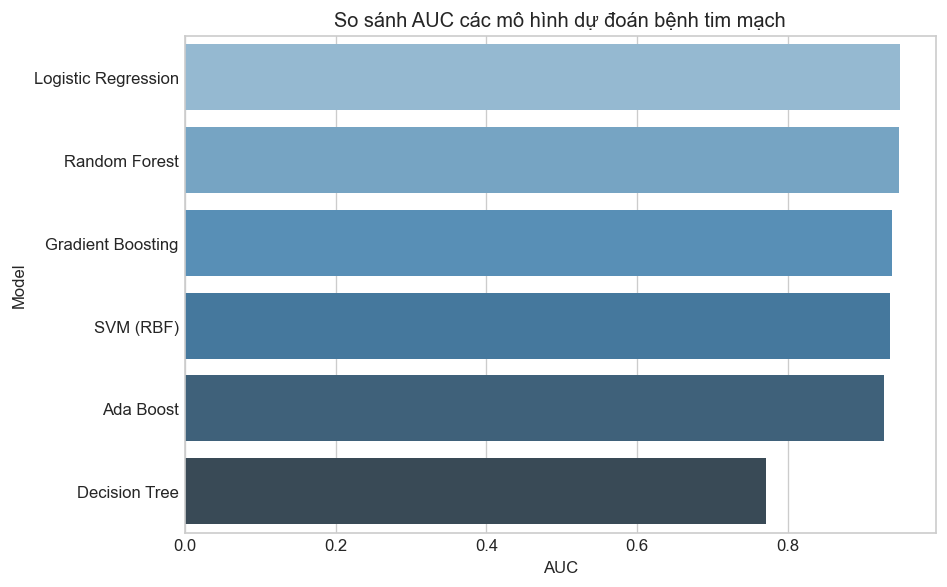

In [117]:
summary = []
for name, mdl in models.items():
    mdl.fit(X_train, y_train)
    y_pred = mdl.predict(X_test)
    y_score = mdl.predict_proba(X_test)[:,1]
    summary.append({
        "Model": name,
        "AUC": roc_auc_score(y_test, y_score),
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred)
    })

results_df = pd.DataFrame(summary).sort_values("AUC", ascending=False)
print("BẢNG SO SÁNH HIỆU NĂNG MÔ HÌNH")
display(results_df)

plt.figure(figsize=(8,5))
sns.barplot(data=results_df, x="AUC", y="Model", palette="Blues_d")
plt.title("So sánh AUC các mô hình dự đoán bệnh tim mạch")
plt.tight_layout()
plt.show(); plt.close()

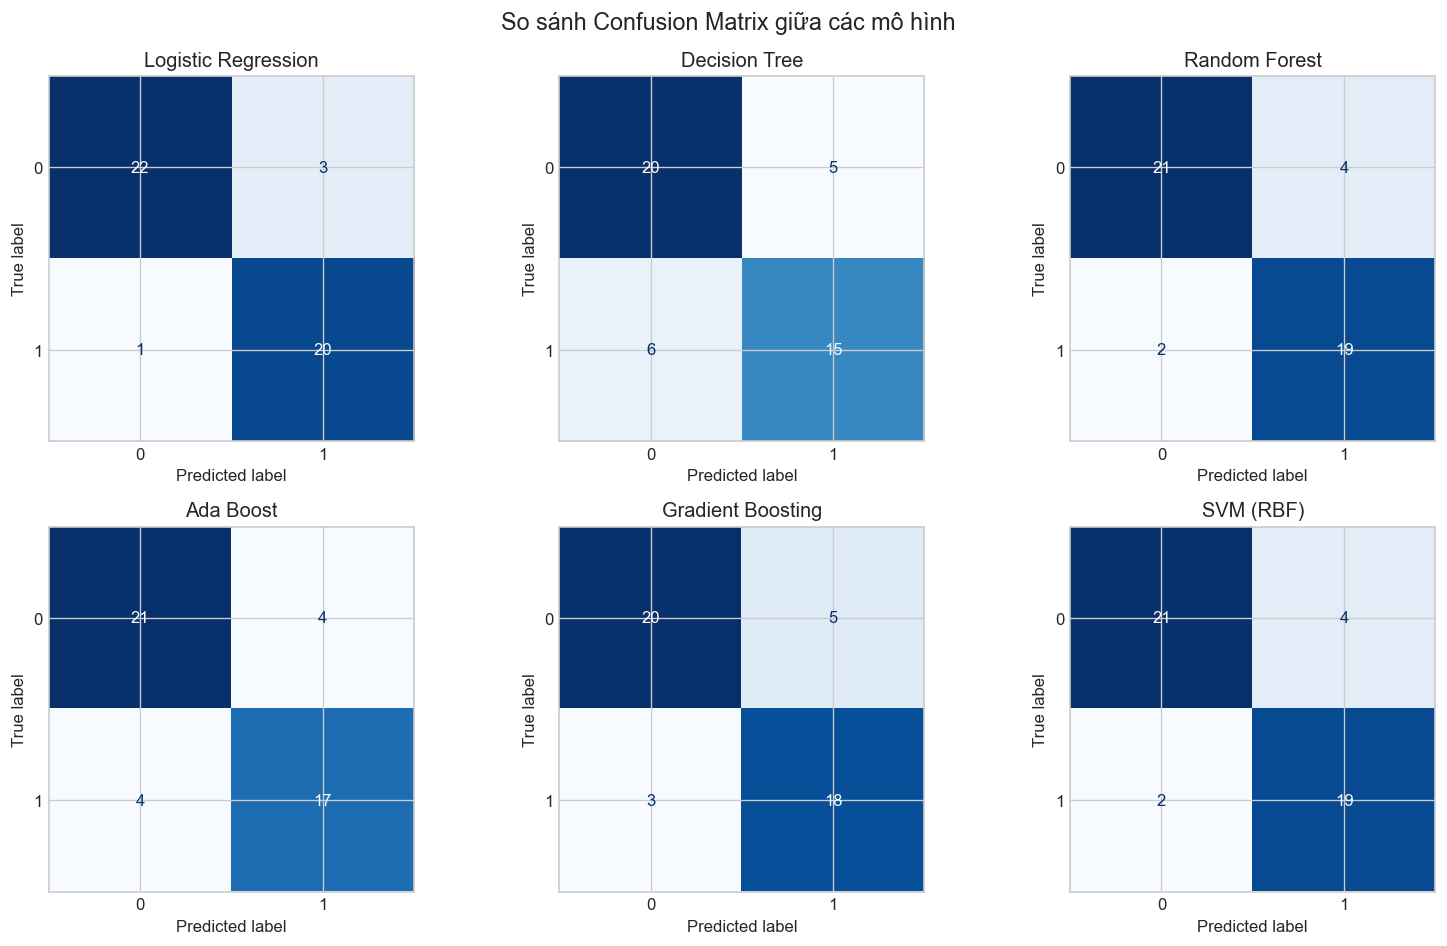

In [118]:
fig, axes = plt.subplots(2, 3, figsize=(13,8))
axes = axes.ravel()

for i, (name, pipe) in enumerate(models.items()):
    # pipe đã fit ở trên; nếu chạy cell này riêng, nhớ fit lại:
    # pipe.fit(X_train, y_train)

    y_pred = pipe.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(ax=axes[i], colorbar=False, cmap="Blues")
    axes[i].set_title(name)

plt.suptitle("So sánh Confusion Matrix giữa các mô hình", fontsize=14)
plt.tight_layout()
plt.show(); plt.close()


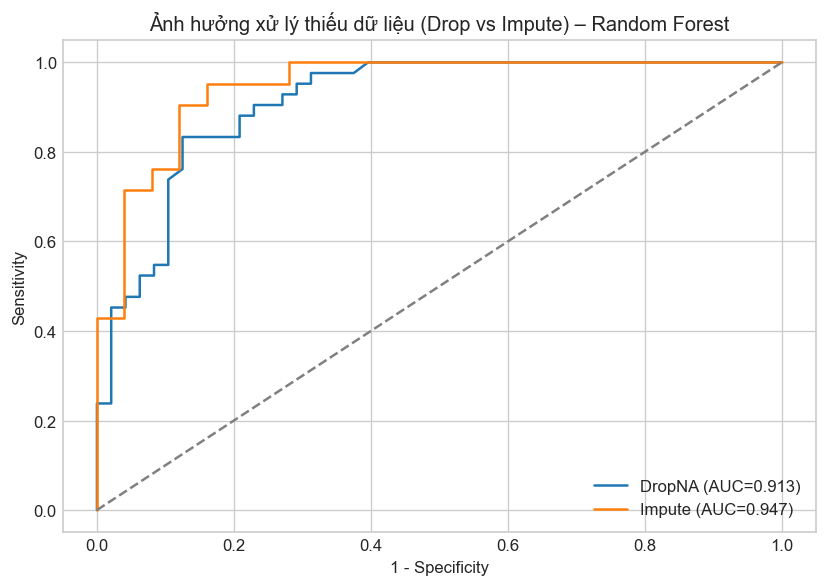

In [119]:
# Chuẩn bị RF với DropNA
df_drop = df.dropna()
X_drop = df_drop.drop(columns=["target"]); y_drop = df_drop["target"]
Xtr_d, Xte_d, ytr_d, yte_d = train_test_split(X_drop, y_drop, test_size=0.3, stratify=y_drop, random_state=42)

preprocess_drop = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])
rf_drop = Pipeline([("pre", preprocess_drop),
                    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"))])
rf_drop.fit(Xtr_d, ytr_d)

# Lấy RF đã dùng imputation (đang ở dict models)
rf_impute = models["Random Forest"]

plt.figure(figsize=(7,5))
for label, mdl, X_t, y_t in [("DropNA", rf_drop, Xte_d, yte_d),
                             ("Impute", rf_impute, X_test, y_test)]:
    y_score = mdl.predict_proba(X_t)[:,1]
    fpr, tpr, _ = roc_curve(y_t, y_score)
    auc = roc_auc_score(y_t, y_score)
    plt.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],"--", color="gray")
plt.title("Ảnh hưởng xử lý thiếu dữ liệu (Drop vs Impute) – Random Forest")
plt.xlabel("1 - Specificity"); plt.ylabel("Sensitivity")
plt.legend(); plt.tight_layout(); plt.show(); plt.close()


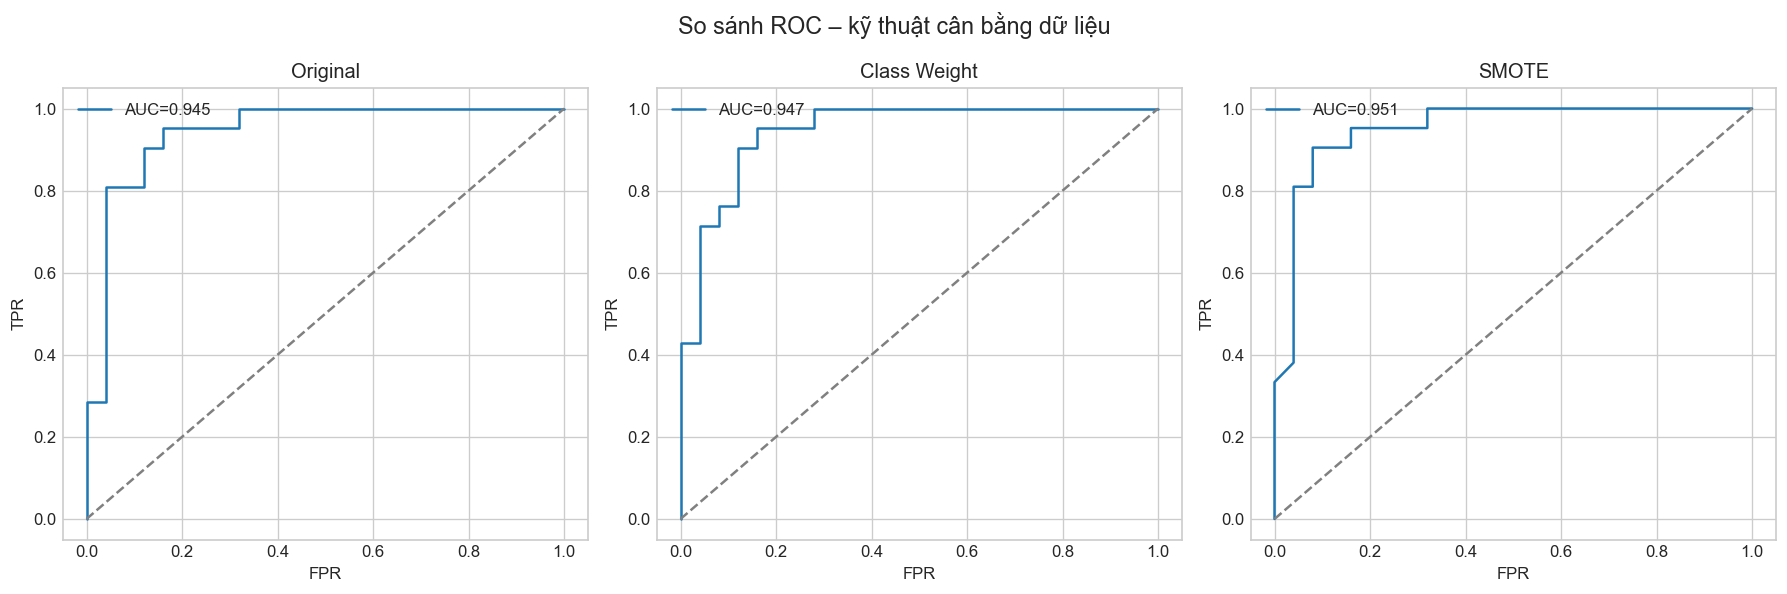

In [120]:
rf_original = Pipeline([("pre", preprocess_impute),
                        ("clf", RandomForestClassifier(n_estimators=400, random_state=42))])

rf_weight = Pipeline([("pre", preprocess_impute),
                      ("clf", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"))])

rf_smote = ImbPipeline([("pre", preprocess_impute),
                        ("smote", SMOTE(random_state=42)),
                        ("clf", RandomForestClassifier(n_estimators=400, random_state=42))])

models_imb = {"Original": rf_original, "Class Weight": rf_weight, "SMOTE": rf_smote}

fig, axes = plt.subplots(1, 3, figsize=(15,5))
for ax, (name, mdl) in zip(axes, models_imb.items()):
    mdl.fit(X_train, y_train)
    y_score = mdl.predict_proba(X_test)[:,1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc = roc_auc_score(y_test, y_score)
    ax.plot(fpr, tpr, label=f"AUC={auc:.3f}")
    ax.plot([0,1],[0,1],"--", color="gray")
    ax.set_title(name); ax.set_xlabel("FPR"); ax.set_ylabel("TPR"); ax.legend()

plt.suptitle("So sánh ROC – kỹ thuật cân bằng dữ liệu", fontsize=14)
plt.tight_layout(); plt.show(); plt.close()


/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_31329/1775350316.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_31329/1775350316.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_31329/1775350316.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_31329/1775350316.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

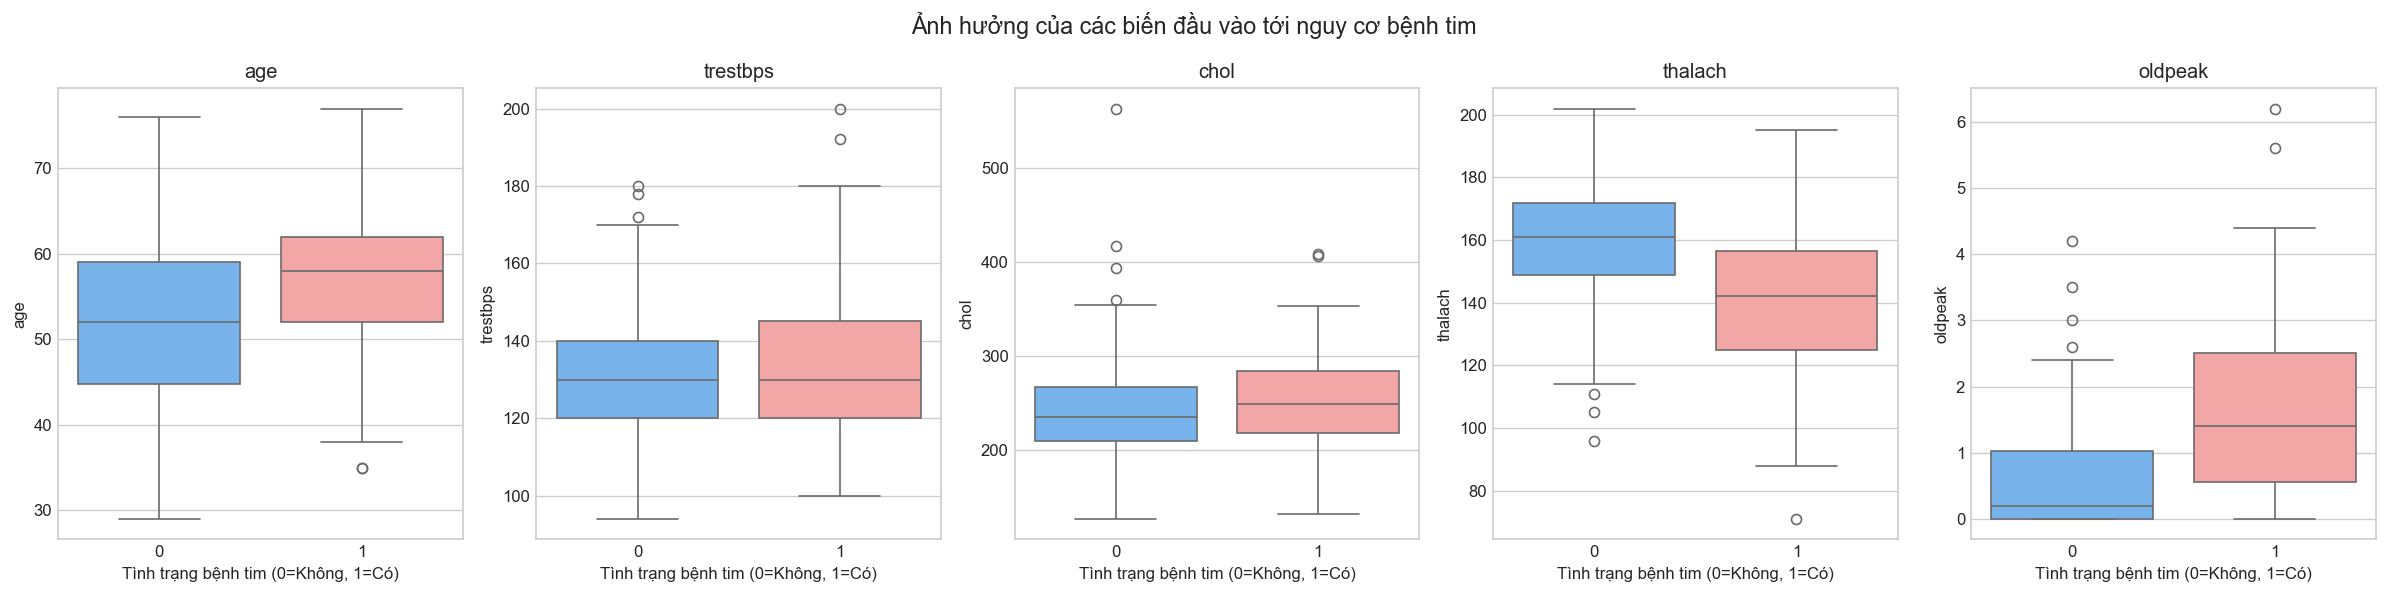

In [121]:

# Ảnh hưởng của các biến đầu vào đến đầu ra (Feature vs Target)
# Chọn một số biến liên tục để phân tích
features_to_plot = ["age", "trestbps", "chol", "thalach", "oldpeak"]

# Thiết lập figure có nhiều boxplot cạnh nhau
fig, axes = plt.subplots(1, len(features_to_plot), figsize=(20,5), sharey=False)

for i, feature in enumerate(features_to_plot):
    sns.boxplot(
        x="target", y=feature, data=df,
        palette=["#66b3ff", "#ff9999"],
        ax=axes[i]
    )
    axes[i].set_xlabel("Tình trạng bệnh tim (0=Không, 1=Có)")
    axes[i].set_title(feature, fontsize=12)

plt.suptitle("Ảnh hưởng của các biến đầu vào tới nguy cơ bệnh tim", fontsize=14)
plt.tight_layout()
plt.show(); plt.close()


/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_31329/994807813.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y=feature, data=df, palette=["#66b3ff","#ff9999"], ax=axes[i])
/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_31329/994807813.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y=feature, data=df, palette=["#66b3ff","#ff9999"], ax=axes[i])
/var/folders/2g/w284bvmx11938jmcbwn9vd8r0000gn/T/ipykernel_31329/994807813.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="target", y=fe

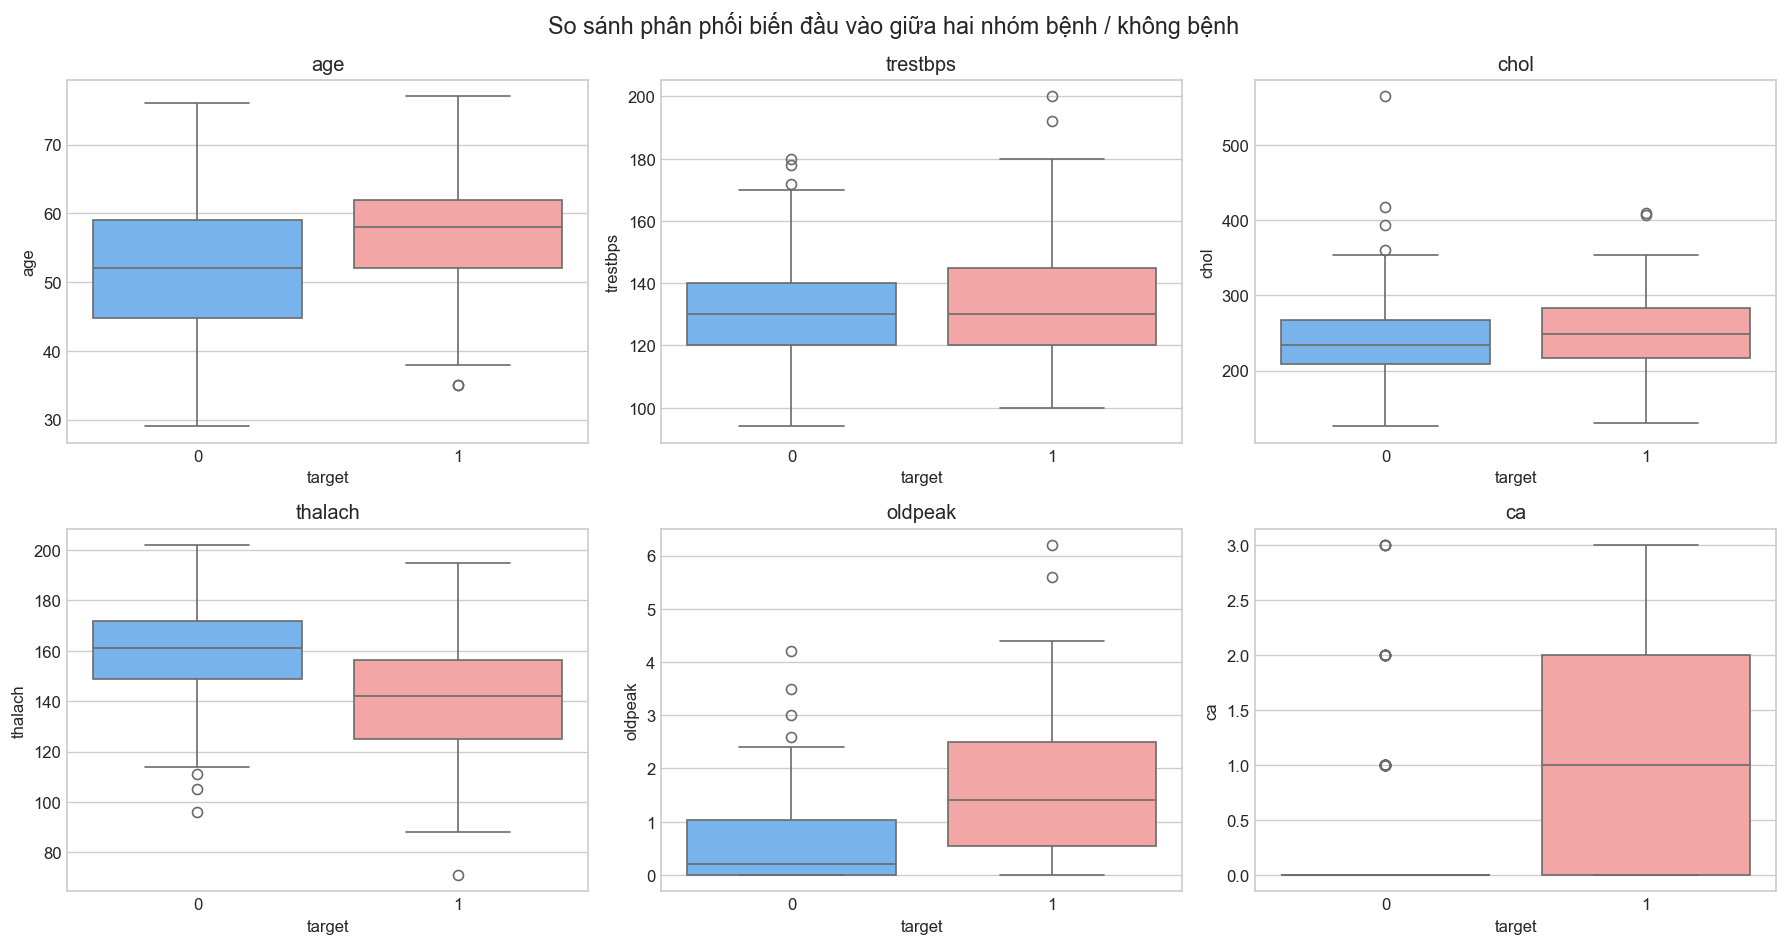

In [122]:
features_to_plot = ["age", "trestbps", "chol", "thalach", "oldpeak", "ca"]

fig, axes = plt.subplots(2, 3, figsize=(15,8))
axes = axes.ravel()
for i, feature in enumerate(features_to_plot):
    sns.boxplot(x="target", y=feature, data=df, palette=["#66b3ff","#ff9999"], ax=axes[i])
    axes[i].set_title(feature)
plt.suptitle("So sánh phân phối biến đầu vào giữa hai nhóm bệnh / không bệnh", fontsize=14)
plt.tight_layout()
plt.show(); plt.close()


In [123]:
df_drop = df.dropna()
X_drop = df_drop.drop(columns=["target"])
y_drop = df_drop["target"]

X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(
    X_drop, y_drop, test_size=0.3, stratify=y_drop, random_state=42
)

preprocess_drop = ColumnTransformer([
    ("num", Pipeline([("scaler", StandardScaler())]), num_cols),
    ("cat", Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

rf_drop = Pipeline([
    ("pre", preprocess_drop),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"))
])

rf_drop.fit(X_train_d, y_train_d)
y_score_drop = rf_drop.predict_proba(X_test_d)[:,1]
auc_drop = roc_auc_score(y_test_d, y_score_drop)

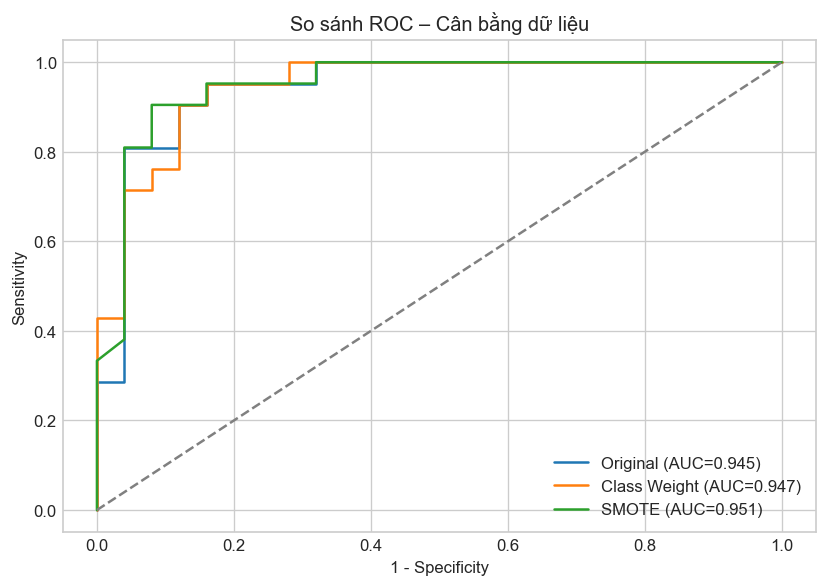

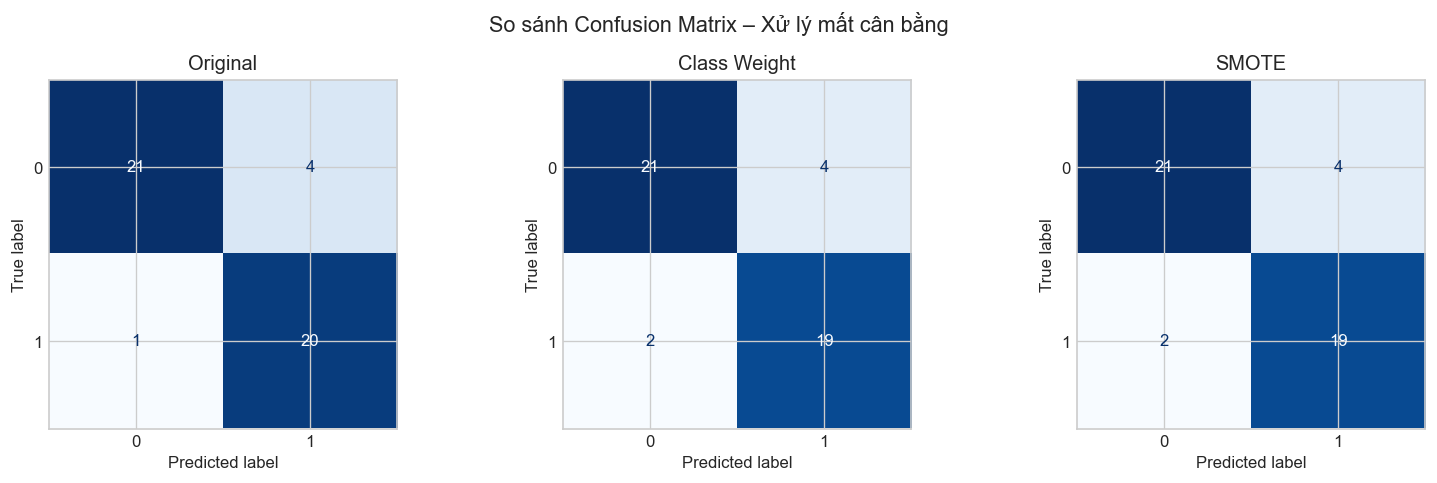

In [124]:


rf_original = Pipeline([
    ("pre", preprocess_impute),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42))
])

rf_weight = Pipeline([
    ("pre", preprocess_impute),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42, class_weight="balanced"))
])

rf_smote = ImbPipeline([
    ("pre", preprocess_impute),
    ("smote", SMOTE(random_state=42)),
    ("clf", RandomForestClassifier(n_estimators=400, random_state=42))
])

models_imb = {"Original": rf_original, "Class Weight": rf_weight, "SMOTE": rf_smote}

# -----------------------------
# Vẽ ROC
# -----------------------------
plt.figure(figsize=(7,5))
for name, mdl in models_imb.items():
    mdl.fit(X_train, y_train)
    y_score = mdl.predict_proba(X_test)[:,1]
    auc = roc_auc_score(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")

plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("1 - Specificity")
plt.ylabel("Sensitivity")
plt.title("So sánh ROC – Cân bằng dữ liệu")
plt.legend()
plt.tight_layout()
plt.show(); plt.close()

# -----------------------------
# Vẽ Confusion Matrix
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(13,4))
for ax, (name, mdl) in zip(axes, models_imb.items()):
    y_pred = mdl.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(ax=ax, colorbar=False, cmap="Blues")
    ax.set_title(name)

plt.suptitle("So sánh Confusion Matrix – Xử lý mất cân bằng", fontsize=13)
plt.tight_layout()
plt.show()
